<center><img src='https://i.postimg.cc/TPR1n1rp/AI-Tech-PL-RGB.png' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://i.postimg.cc/Gpq2KRQz/logotypy-aitech.jpg'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
</center>

# Lab 06-bis

Run SAC on one of the MuJoCo environments using the implementation from https://github.com/awarelab/spinningup_tf2

In [1]:
!apt -q update 
!apt install -q -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg
!pip -q install gdown

# Installing dependencies for visualization
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install -U gym==0.19
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
import os

MJC_PATH = '/content/mujoco'
if not os.path.exists(MJC_PATH):
    %mkdir $MJC_PATH

if not os.path.exists(f'{MJC_PATH}/mujoco210'):
    %cd $MJC_PATH
    !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz
    !tar -xzf mujoco210-linux-x86_64.tar.gz
    %rm mujoco210-linux-x86_64.tar.gz

/content/mujoco


In [3]:
os.environ['LD_LIBRARY_PATH'] += ':{}/mujoco210/bin'.format(MJC_PATH)
os.environ['MUJOCO_PY_MUJOCO_PATH'] = '{}/mujoco210'.format(MJC_PATH)

# Installation on colab does not find *.so files in LD_LIBRARY_PATH,
# copy over manually instead.
!cp $MJC_PATH/mujoco210/bin/*.so /usr/lib/x86_64-linux-gnu/

In [4]:
if not os.path.exists(f'{MJC_PATH}/mujoco-py'):
    %cd $MJC_PATH
    !git clone https://github.com/openai/mujoco-py.git

%cd $MJC_PATH/mujoco-py
!git checkout f1312cceeeebbba17e78d5d77fbffa091eed9a3a # Tested version
%pip install -e .

# Compile at the first import
import mujoco_py

/content/mujoco
Cloning into 'mujoco-py'...
remote: Enumerating objects: 2183, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 2183 (delta 7), reused 8 (delta 3), pack-reused 2148
Receiving objects: 100% (2183/2183), 5.70 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (1350/1350), done.
/content/mujoco/mujoco-py
Note: checking out 'f1312cceeeebbba17e78d5d77fbffa091eed9a3a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at f1312cc Bump version for release
Obtaining file:///content/mujoco/mujoco-py
  Installing build dependencies ... done
  Getting requireme

In [17]:
import glob
import time

from functools import partial

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()

# Seed random generators
tf.random.set_seed(42)
np.random.seed(42)

# Helpers

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

def render_agent(env, model=None):
    envw = gym.wrappers.Monitor(env, "./", force=True)
    o, d = envw.reset(), False
    while not d:
        envw.render()
        if model is not None:
            act = model(tf.expand_dims(o, axis=0))[0]
        else:
            act = env.action_space.sample()
        o, _, d, _ = envw.step(act)
    # envw.close()

    file_name = glob.glob('openaigym.video.*.mp4')[0]
    return show_video(file_name)

In [18]:
env = gym.make('Ant-v2')
render_agent(env)

Creating window glfw


In [36]:
# Parameters
hidden_sizes=(64, 64) # Actor and critic networks sizes
total_steps=100_000 # Number of environment interactions to run and train on
replay_size=100_000 # Maximum length of replay buffer
gamma=0.99 # Discount factor (Always between 0 and 1.)
polyak=0.995 # Interpolation factor in polyak averaging for target networks
lr=0.001 # Learning rate (used for both policy and value learning)
alpha=0.2 # Entropy regularization coefficient (Equivalent to inverse of reward scale in the original SAC paper)
batch_size=256 # Minibatch size for SGD
start_steps=5_000 # Warm-up steps (uniform-random actions) before running real policy
update_after=512 # Number of env interactions to collect before starting to do gradient descent updates (Ensures replay buffer is full enough for useful updates)
update_every=50 # Number of env interactions that should elapse between gradient descent updates
max_ep_len=500 # Maximum length of trajectory / episode / rollout
num_test_episodes=30 # Number of episodes to test the deterministic policy at the end of training

# Constants
EPS = 1e-8

LOG_STD_MAX = 2
LOG_STD_MIN = -20

In [37]:
# Helper functions

def gaussian_likelihood(value, mu, log_std):
    """Calculates value's likelihood under Gaussian pdf."""
    pre_sum = -0.5 * (
        ((value - mu) / (tf.exp(log_std) + EPS)) ** 2 +
        2 * log_std + np.log(2 * np.pi)
    )
    return tf.reduce_sum(pre_sum, axis=1)


def apply_squashing_func(mu, pi, logp_pi):
    """Applies adjustment to mean, pi and log prob.

    This formula is a little bit magic. To get an understanding of where it
    comes from, check out the original SAC paper (arXiv 1801.01290) and look
    in appendix C. This is a more numerically-stable equivalent to Eq 21.
    Try deriving it yourself as a (very difficult) exercise. :)
    """
    logp_pi -= tf.reduce_sum(
        2 * (np.log(2) - pi - tf.nn.softplus(-2 * pi)), axis=1)

    # Squash those unbounded actions!
    mu = tf.tanh(mu)
    pi = tf.tanh(pi)
    return mu, pi, logp_pi


def mlp(hidden_sizes, activation, name=None):
    """Create the Multi-Layer Perceptron model."""
    return tf.keras.Sequential([
        tf.keras.layers.Dense(size, activation=activation)
        for size in hidden_sizes
    ], name)

In [38]:
def make_actor(observation_space, action_space,
               hidden_sizes=(256, 256),
               activation=tf.nn.relu):
    """Create the actor's tf.keras.Model."""
    obs_dim = observation_space.shape[0]
    act_dim = action_space.shape[0]
    act_scale = action_space.high[0]

    obs_input = tf.keras.Input(shape=(obs_dim,))

    # Exercise: Define the actor's model
    body = mlp(hidden_sizes=hidden_sizes, activation=activation)(obs_input)
    mu = tf.keras.layers.Dense(act_dim)(body)
    log_std = tf.keras.layers.Dense(act_dim)(body)

    # Note: Clip the log std. dev. between [LOG_STD_MIN, LOG_STD_MAX].

    log_std = tf.clip_by_value(log_std, LOG_STD_MIN, LOG_STD_MAX)
    std = tf.exp(log_std)
    pi = mu + tf.random.normal(tf.shape(input=mu)) * std
    logp_pi = gaussian_likelihood(pi, mu, log_std)

    mu, pi, logp_pi = apply_squashing_func(mu, pi, logp_pi)

    # Make sure actions are in the correct range
    mu *= act_scale
    pi *= act_scale

    return tf.keras.Model(inputs=obs_input, outputs=[mu, pi, logp_pi])

In [39]:
def make_critic(observation_space, action_space,
                hidden_sizes=(256, 256),
                activation=tf.nn.relu):
    """Create the critic's tf.keras.Model."""
    obs_dim = observation_space.shape[0]
    act_dim = action_space.shape[0]

    obs_input = tf.keras.Input(shape=(obs_dim,))
    act_input = tf.keras.Input(shape=(act_dim,))
    concat_input = tf.keras.layers.Concatenate(axis=-1)([obs_input, act_input])

    # Exercise: Define the critic's model

    value = tf.keras.Sequential([
        mlp(hidden_sizes, activation),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Reshape([])
    ])(concat_input)

    return tf.keras.Model(inputs=[obs_input, act_input], outputs=value)

In [40]:
@tf.function
def learn_on_batch(obs1, obs2, acts, rews, done):
    with tf.GradientTape(persistent=True) as g:
        # Main outputs from computation graph.
        _, pi, logp_pi = actor(obs1)
        q1 = critic1([obs1, acts])
        q2 = critic2([obs1, acts])

        # Compose q with pi, for pi-learning.
        q1_pi = critic1([obs1, pi])
        q2_pi = critic2([obs1, pi])

        # Get actions and log probs of actions for next states.
        _, pi_next, logp_pi_next = actor(obs2)

        # Target Q-values, using actions from *current* policy.
        target_q1 = target_critic1([obs2, pi_next])
        target_q2 = target_critic2([obs2, pi_next])

        # Min Double-Q:
        min_q_pi = tf.minimum(q1_pi, q2_pi)
        min_target_q = tf.minimum(target_q1, target_q2)

        # Exercise: Implement the actor-critic losses
        # Use these parameters
        #   - Discount factor: `gamma`
        #   - Entropy regularization coefficient: `alpha`
        q_backup = tf.stop_gradient(rews + gamma * (1 - done) * (
                min_target_q - alpha * logp_pi_next))
        
        pi_loss = tf.reduce_mean(alpha * logp_pi - min_q_pi)
        q1_loss = tf.reduce_mean((q_backup - q1) ** 2)
        q2_loss = tf.reduce_mean((q_backup - q2) ** 2)
        value_loss = (q1_loss + q2_loss) * 0.5

    # Compute gradients and do updates.
    actor_gradients = g.gradient(pi_loss, actor.trainable_variables)
    optimizer.apply_gradients(
        zip(actor_gradients, actor.trainable_variables))
    critic_gradients = g.gradient(value_loss, critic_variables)
    optimizer.apply_gradients(
        zip(critic_gradients, critic_variables))
    del g

    # Exercise: Implement the polyak averaging for target variables.
    # Use the interpolation factor parameter: `polyak`.
    
    for v, target_v in zip(critic1.trainable_variables,
                            target_critic1.trainable_variables):
      target_v.assign(polyak * target_v + (1 - polyak) * v)
    for v, target_v in zip(critic2.trainable_variables,
                            target_critic2.trainable_variables):
      target_v.assign(polyak * target_v + (1 - polyak) * v)
    return pi_loss, q1_loss, q2_loss

In [41]:
class ReplayBuffer:
    """A simple FIFO experience replay buffer for SAC agents."""

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=tf.convert_to_tensor(self.obs1_buf[idxs]),
                    obs2=tf.convert_to_tensor(self.obs2_buf[idxs]),
                    acts=tf.convert_to_tensor(self.acts_buf[idxs]),
                    rews=tf.convert_to_tensor(self.rews_buf[idxs]),
                    done=tf.convert_to_tensor(self.done_buf[idxs]))

In [42]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

@tf.function
def get_action(o, deterministic=tf.constant(False)):
    mu, pi, _ = actor(tf.expand_dims(o, 0))
    if deterministic:
        return mu[0]
    else:
        return pi[0]

# Experience buffer.
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim,
                                size=replay_size)

# Build an actor
actor = make_actor(env.observation_space, env.action_space, hidden_sizes)

# Build critics
critic1 = make_critic(env.observation_space, env.action_space, hidden_sizes)
critic2 = make_critic(env.observation_space, env.action_space, hidden_sizes)

input_shape = [(None, obs_dim), (None, act_dim)]


In [43]:
critic1.build(input_shape)  # Initialize weights.
target_critic1 = tf.keras.models.clone_model(critic1)
target_critic1.set_weights(critic1.get_weights())

critic2.build(input_shape)  # Initialize weights.
target_critic2 = tf.keras.models.clone_model(critic2)
target_critic2.set_weights(critic2.get_weights())

critic_variables = critic1.trainable_variables + critic2.trainable_variables

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

start_time = time.time()
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch.
ep_rets, pi_losses, q1_losses, q2_losses = [], [], [], []
for t in range(total_steps):
    iter_time = time.time()

    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards,
    # use the learned policy.
    if t > start_steps:
        a = get_action(tf.convert_to_tensor(o))
    else:
        a = env.action_space.sample()

    # Step the environment.
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state).
    d = False if ep_len == max_ep_len else d

    # Store experience to replay buffer.
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update
    # most recent observation!
    o = o2

    # End of trajectory handling.
    if d or (ep_len == max_ep_len):
        print(f"{t+1:5} | Ep. length: {ep_len:4}; Ep. return: {ep_ret:4.0f};")
        ep_rets.append(ep_ret)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling.
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            pi_loss, q1_loss, q2_loss = learn_on_batch(**batch)
            pi_losses.append(pi_loss)
            q1_losses.append(q1_loss)
            q2_losses.append(q2_loss)

   12 | Ep. length:   12; Ep. return:    7;
   78 | Ep. length:   66; Ep. return:  -16;
  109 | Ep. length:   31; Ep. return:   11;
  198 | Ep. length:   89; Ep. return:  -17;
  698 | Ep. length:  500; Ep. return: -173;
  742 | Ep. length:   44; Ep. return:   14;
  908 | Ep. length:  166; Ep. return:  -62;
  984 | Ep. length:   76; Ep. return:  -19;
 1032 | Ep. length:   48; Ep. return:  -26;
 1060 | Ep. length:   28; Ep. return:    1;
 1173 | Ep. length:  113; Ep. return:  -36;
 1451 | Ep. length:  278; Ep. return:  -51;
 1743 | Ep. length:  292; Ep. return:  -75;
 1797 | Ep. length:   54; Ep. return:    3;
 1903 | Ep. length:  106; Ep. return:  -16;
 2102 | Ep. length:  199; Ep. return:  -70;
 2190 | Ep. length:   88; Ep. return:  -10;
 2220 | Ep. length:   30; Ep. return:   -2;
 2296 | Ep. length:   76; Ep. return:  -13;
 2358 | Ep. length:   62; Ep. return:  -49;
 2413 | Ep. length:   55; Ep. return:  -19;
 2913 | Ep. length:  500; Ep. return: -219;
 3149 | Ep. length:  236; Ep. re

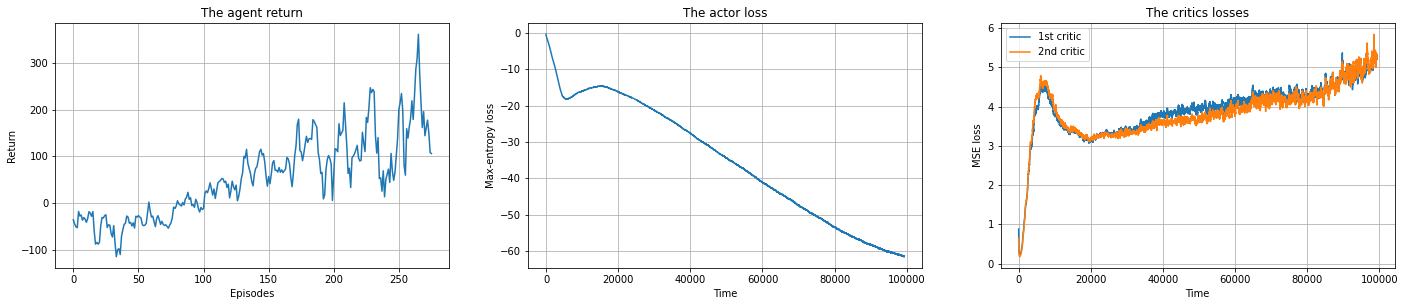

In [44]:
# Plot the result

def sliding_window(values, span):
    cumsum = np.cumsum(values)
    return (cumsum[span:] - cumsum[:-span]) / float(span)

nrows, ncols = 1, 3
dx, dy = 16, 9
scale = 1.5
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols)) * scale
plt.figure(figsize=figsize)

plt.subplot(nrows, ncols, 1)

plt.plot(sliding_window(ep_rets, 5))
plt.title('The agent return')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.grid()

plt.subplot(nrows, ncols, 2)

plt.plot(sliding_window(pi_losses, 200))
plt.title('The actor loss')
plt.xlabel('Time')
plt.ylabel('Max-entropy loss')
plt.grid()

plt.subplot(nrows, ncols, 3)

plt.plot(sliding_window(q1_losses, 200), label='1st critic')
plt.plot(sliding_window(q2_losses, 200), label='2nd critic')
plt.title('The critics losses')
plt.xlabel('Time')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()

plt.show()

In [45]:
total_ret, total_len = 0, 0
for _ in range(num_test_episodes):
    o, d, ep_len = env.reset(), False, 0
    while not (d or (ep_len == max_ep_len)):
        # Take deterministic actions at test time.
        o, r, d, info = env.step(
            get_action(tf.convert_to_tensor(o), tf.constant(True)))
        total_ret += r
        ep_len += 1
    total_len += ep_len
print(f"TEST | Ep. length: {total_len/num_test_episodes:4}; Ep. return: {total_ret/num_test_episodes:4.0f};")

TEST | Ep. length: 470.3; Ep. return:  544;
